In [88]:
import os
import datetime
import sklearn.preprocessing as pp
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import tempfile

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['axes.grid'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [89]:
# df_4t = pd.read_csv('ds6_all.csv')
df_ev = pd.read_csv('dataset_all.csv')

In [90]:
df = df_ev

In [91]:
# df = df.groupby(['날짜','구']).sum().reset_index()
ohe = pp.OneHotEncoder()
ohe_gu = pd.DataFrame(ohe.fit_transform(df['구'].values.reshape(-1,1)).toarray(),
            columns=sorted(list(set(df['구']))))

In [92]:
df.pop('구')
df.pop('추정유동인구')
df.pop('싸락우박')
# df.pop('시간')
df['class'] = df['건수'].apply(lambda x: 1 if x == True else 0)
df.pop('건수')
df = pd.concat([ohe_gu, df], axis =1)

# 시간값 처리

sin, cos 으로 변환하여 순환하는 값으로 입력

In [93]:
date = df.pop('날짜').apply(str)
time = df.pop('시간').apply(lambda x: '{0:0>2}'.format(str(x)))

In [94]:
date_time = date + ' ' + time

In [95]:
date_time = pd.to_datetime(date_time, format='%Y%m%d %H')
# date_time = pd.to_datetime(date_time, format='%Y%m%d')

In [96]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [97]:
# hour = 60*60
day = 24*60*60
year = (365.2425)*24*60*60

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of Year signal')

D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


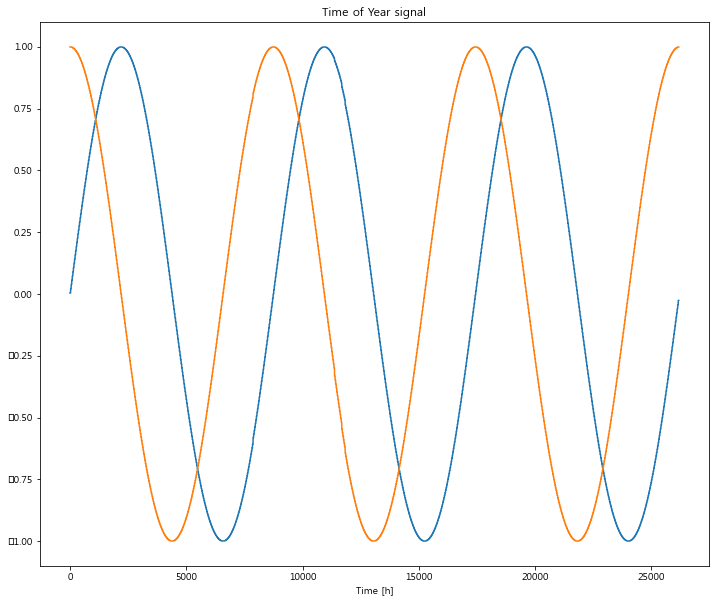

In [98]:
plt.plot(np.array(df['Year sin'])[::24])
plt.plot(np.array(df['Year cos'])[::24])
plt.xlabel('Time [h]')
plt.title('Time of Year signal')

### 변환한 값으로 그래프를 그려보면 아래와 같다.

의미 : 매 주기(일 혹은 년) 마다 

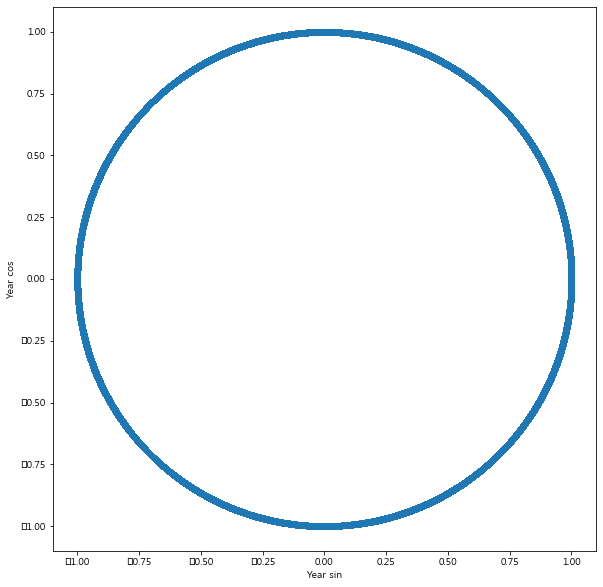

In [99]:
df.plot.scatter('Year sin','Year cos').set_aspect('equal');

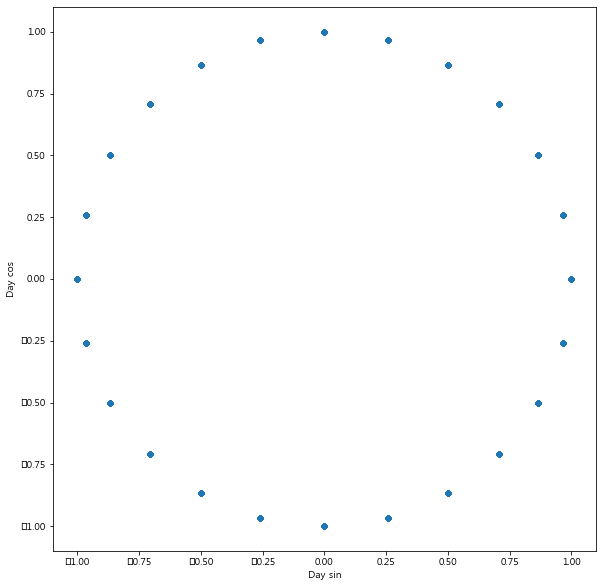

In [100]:
df.plot.scatter('Day sin','Day cos').set_aspect('equal');

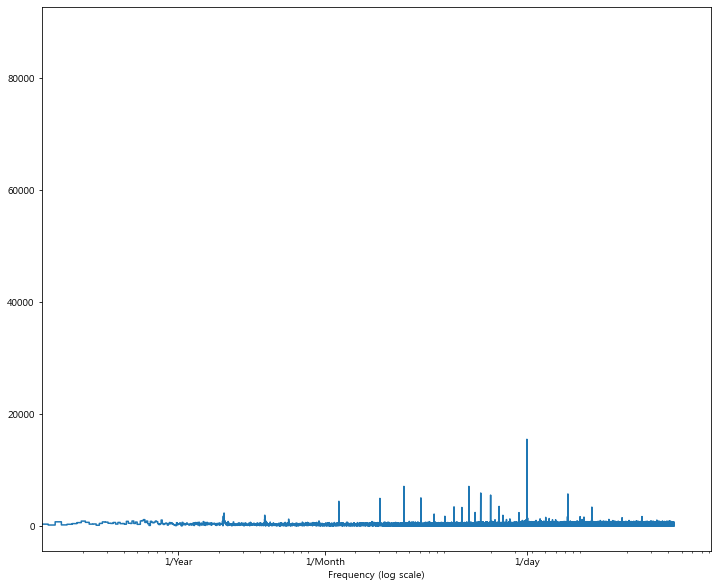

In [101]:
fft = tf.signal.rfft(df['class'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['class'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 12, 365.2524], labels=['1/Year', '1/Month', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [102]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [103]:
train_y = train_df['class']
val_y = val_df['class']
test_y = test_df['class']

In [104]:
train_df.drop('class', axis=1, inplace=True)
val_df.drop('class', axis=1, inplace=True)
test_df.drop('class', axis=1, inplace=True)

D:\anaconda\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [105]:
train_mean = train_df.mean()
train_std = train_df.std()

In [106]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [107]:
train_df = pd.concat([train_df,train_y], axis=1)
val_df = pd.concat([val_df,val_y], axis=1)
test_df = pd.concat([test_df,test_y], axis=1)

In [108]:
neg, pos = np.bincount(df['class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 628416
    Positive: 88258 (14.04% of total)



In [109]:
# 계산시간 오래걸려서 막아둠

# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

# 데이터 윈도우

In [110]:
# cleaned_df = df.copy()

In [111]:
# # Use a utility from sklearn to split and shuffle our dataset.
# train_df, test_df = train_test_split(cleaned_df, test_size=0.1)
# train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('class'))
test_labels = np.array(test_df.pop('class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


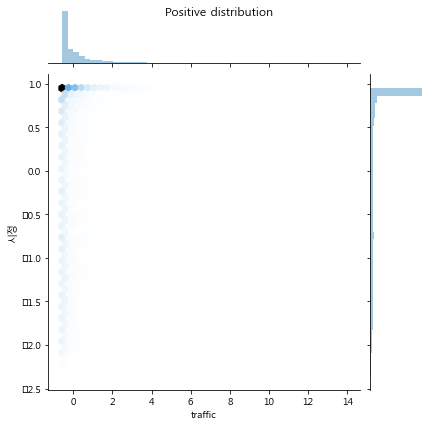

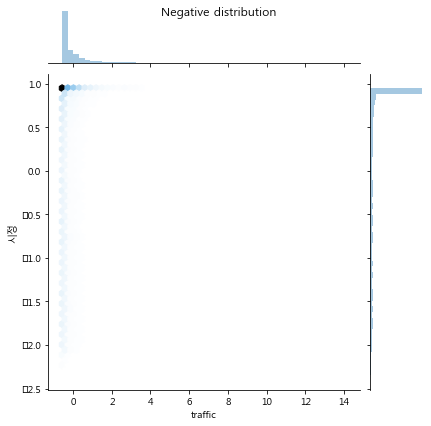

In [112]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

sns.jointplot(pos_df['traffic'], pos_df['시정'],
              kind='hex') # , xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['traffic'], neg_df['시정'],
              kind='hex') # , xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

# 모델링

In [113]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          64, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
#       keras.layers.Dense(128, activation='relu'),
#       keras.layers.Dropout(0.3),
#       keras.layers.Dense(64, activation='relu'),
#       keras.layers.Dropout(0.3),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [114]:
EPOCHS = 10000
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

In [115]:
model = make_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                2944      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


#### 초기 편향 설정 - 첫 loss 감소시켜줌 (학습효율 증가)

In [116]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.81159735])

In [117]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.20834279],
       [0.19848144],
       [0.19952518],
       [0.1351504 ],
       [0.13056758],
       [0.12454051],
       [0.11959431],
       [0.115742  ],
       [0.1127708 ],
       [0.11067942]], dtype=float32)

In [118]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4615


#### 초기 가중치 체크포인트

In [119]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [120]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

# 여기까지 성능 비교 

# 아래부터 모델 학습

In [121]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/10000
215/215 [==============================] - 2s 11ms/step - loss: 0.4295 - tp: 2388.0000 - fp: 12106.0000 - tn: 744932.0000 - fn: 120356.0000 - accuracy: 0.8494 - precision: 0.1648 - recall: 0.0195 - auc: 0.5330 - val_loss: 0.3995 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6194
Epoch 2/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.4016 - tp: 62.0000 - fp: 378.0000 - tn: 378141.0000 - fn: 61310.0000 - accuracy: 0.8598 - precision: 0.1409 - recall: 0.0010 - auc: 0.5912 - val_loss: 0.3961 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6262
Epoch 3/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3966 - tp: 35.0000 - fp: 107.0000 - tn: 378412.0000 - fn: 61337.0000 - accuracy: 0.

Epoch 21/10000
215/215 [==============================] - 1s 6ms/step - loss: 0.3927 - tp: 2.0000 - fp: 14.0000 - tn: 378505.0000 - fn: 61370.0000 - accuracy: 0.8605 - precision: 0.1250 - recall: 3.2588e-05 - auc: 0.6232 - val_loss: 0.3940 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6346
Epoch 22/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3927 - tp: 3.0000 - fp: 9.0000 - tn: 378510.0000 - fn: 61369.0000 - accuracy: 0.8605 - precision: 0.2500 - recall: 4.8882e-05 - auc: 0.6233 - val_loss: 0.3936 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_tn: 107900.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6350
Epoch 23/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3927 - tp: 4.0000 - fp: 5.0000 - tn: 378514.0000 - fn: 61368.0000 - accuracy: 0.8605 - 

Epoch 41/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3924 - tp: 1.0000 - fp: 1.0000 - tn: 378518.0000 - fn: 61371.0000 - accuracy: 0.8605 - precision: 0.5000 - recall: 1.6294e-05 - auc: 0.6250 - val_loss: 0.3934 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6358
Epoch 42/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3922 - tp: 1.0000 - fp: 3.0000 - tn: 378516.0000 - fn: 61371.0000 - accuracy: 0.8605 - precision: 0.2500 - recall: 1.6294e-05 - auc: 0.6257 - val_loss: 0.3936 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6349
Epoch 43/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3923 - tp: 1.0000 - fp: 0.0000e+00 - tn: 378519.0000 - fn: 61371.0000 - accuracy: 0.

215/215 [==============================] - 1s 7ms/step - loss: 0.3923 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 378519.0000 - fn: 61372.0000 - accuracy: 0.8605 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6255 - val_loss: 0.3937 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6352
Epoch 61/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3922 - tp: 0.0000e+00 - fp: 2.0000 - tn: 378517.0000 - fn: 61372.0000 - accuracy: 0.8605 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6257 - val_loss: 0.3936 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6350
Epoch 62/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3922 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 378519.0000 - fn: 61372.0000 - acc

215/215 [==============================] - 1s 7ms/step - loss: 0.3921 - tp: 0.0000e+00 - fp: 1.0000 - tn: 378518.0000 - fn: 61372.0000 - accuracy: 0.8605 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6263 - val_loss: 0.3938 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6346
Epoch 80/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3921 - tp: 0.0000e+00 - fp: 1.0000 - tn: 378518.0000 - fn: 61372.0000 - accuracy: 0.8605 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6265 - val_loss: 0.3938 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6345
Epoch 81/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3921 - tp: 1.0000 - fp: 0.0000e+00 - tn: 378519.0000 - fn: 61371.0000 - accuracy: 0

215/215 [==============================] - 1s 7ms/step - loss: 0.3920 - tp: 1.0000 - fp: 2.0000 - tn: 378517.0000 - fn: 61371.0000 - accuracy: 0.8605 - precision: 0.3333 - recall: 1.6294e-05 - auc: 0.6269 - val_loss: 0.3938 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6344
Epoch 99/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3920 - tp: 0.0000e+00 - fp: 2.0000 - tn: 378517.0000 - fn: 61372.0000 - accuracy: 0.8605 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6268 - val_loss: 0.3934 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6357
Epoch 100/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3921 - tp: 3.0000 - fp: 1.0000 - tn: 378518.0000 - fn: 61369.0000 - accuracy: 0.8605 - pre

215/215 [==============================] - 1s 7ms/step - loss: 0.3920 - tp: 3.0000 - fp: 0.0000e+00 - tn: 378519.0000 - fn: 61369.0000 - accuracy: 0.8605 - precision: 1.0000 - recall: 4.8882e-05 - auc: 0.6270 - val_loss: 0.3938 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6347
Epoch 118/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3920 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 378519.0000 - fn: 61372.0000 - accuracy: 0.8605 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6270 - val_loss: 0.3937 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6348
Epoch 119/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3921 - tp: 3.0000 - fp: 5.0000 - tn: 378514.0000 - fn: 61369.0000 - accuracy: 0.8

Epoch 137/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3921 - tp: 2.0000 - fp: 8.0000 - tn: 378511.0000 - fn: 61370.0000 - accuracy: 0.8605 - precision: 0.2000 - recall: 3.2588e-05 - auc: 0.6262 - val_loss: 0.3937 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6348
Epoch 138/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3919 - tp: 1.0000 - fp: 4.0000 - tn: 378515.0000 - fn: 61371.0000 - accuracy: 0.8605 - precision: 0.2000 - recall: 1.6294e-05 - auc: 0.6275 - val_loss: 0.3939 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 107902.0000 - val_fn: 17781.0000 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6339
Epoch 139/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.3920 - tp: 0.0000e+00 - fp: 2.0000 - tn: 378517.0000 - fn: 61372.0000 - accuracy:

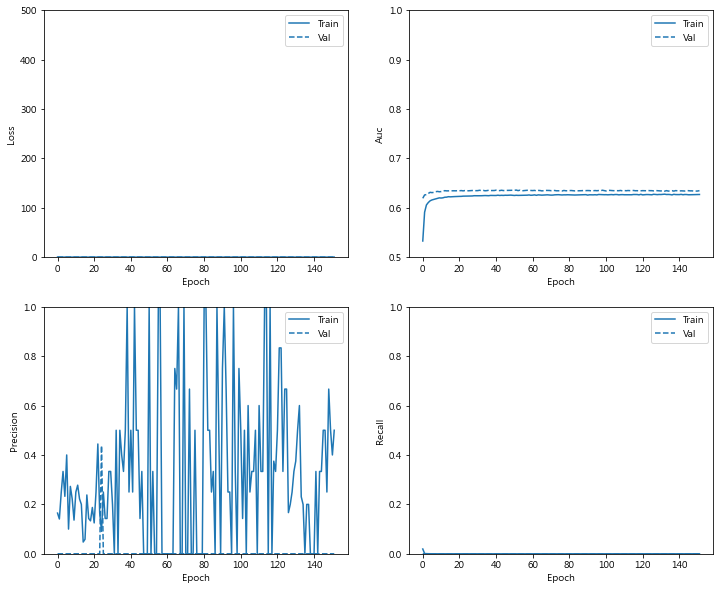

In [122]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, 500])
    elif metric == 'auc':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])

    plt.legend()

    plt.legend()
plot_metrics(baseline_history)

# 메트릭 평가

### 혼동행렬

In [123]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [124]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.3987486958503723
tp :  0.0
fp :  0.0
tn :  53737.0
fn :  9105.0
accuracy :  0.8551128506660461
precision :  0.0
recall :  0.0
auc :  0.6385252475738525

Legitimate Transactions Detected (True Negatives):  53737
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  9105
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  9105


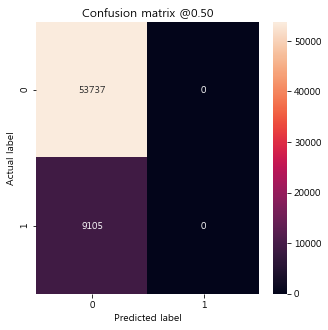

In [125]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

### ROC 그리기

In [126]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-1,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

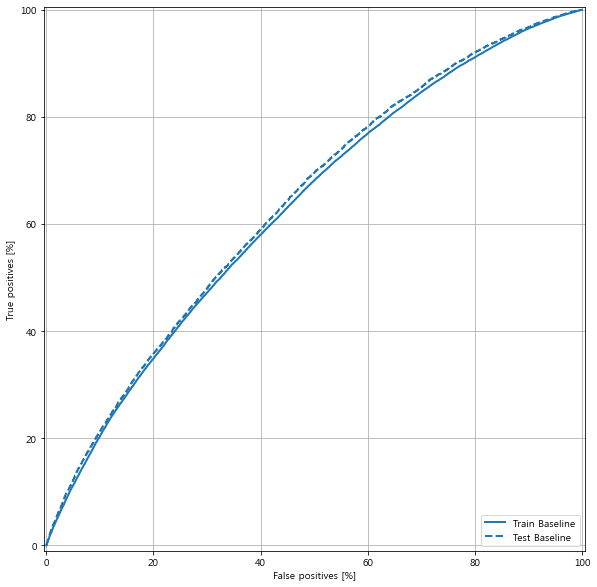

In [127]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

## 클래스 가중치

In [128]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.58
Weight for class 1: 3.56


In [129]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/10000
215/215 [==============================] - 2s 11ms/step - loss: 0.7683 - tp: 27421.0000 - fp: 140310.0000 - tn: 291946.0000 - fn: 43056.0000 - accuracy: 0.6353 - precision: 0.1635 - recall: 0.3891 - auc: 0.5433 - val_loss: 0.6310 - val_tp: 8167.0000 - val_fp: 32325.0000 - val_tn: 75577.0000 - val_fn: 9614.0000 - val_accuracy: 0.6663 - val_precision: 0.2017 - val_recall: 0.4593 - val_auc: 0.6207
Epoch 2/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.7057 - tp: 28871.0000 - fp: 137735.0000 - tn: 240784.0000 - fn: 32501.0000 - accuracy: 0.6130 - precision: 0.1733 - recall: 0.4704 - auc: 0.5760 - val_loss: 0.6401 - val_tp: 8547.0000 - val_fp: 33718.0000 - val_tn: 74184.0000 - val_fn: 9234.0000 - val_accuracy: 0.6583 - val_precision: 0.2022 - val_recall: 0.4807 - val_auc: 0.6255
Epoch 3/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6910 - tp: 29348.0000 - fp: 134704.0000 - tn: 243815.0000 - fn: 32024.0000 - accuracy: 0.6210 - pr

Epoch 21/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6683 - tp: 34882.0000 - fp: 150591.0000 - tn: 227928.0000 - fn: 26490.0000 - accuracy: 0.5974 - precision: 0.1881 - recall: 0.5684 - auc: 0.6211 - val_loss: 0.6610 - val_tp: 10474.0000 - val_fp: 43566.0000 - val_tn: 64336.0000 - val_fn: 7307.0000 - val_accuracy: 0.5952 - val_precision: 0.1938 - val_recall: 0.5891 - val_auc: 0.6349
Epoch 22/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6679 - tp: 34922.0000 - fp: 151659.0000 - tn: 226860.0000 - fn: 26450.0000 - accuracy: 0.5951 - precision: 0.1872 - recall: 0.5690 - auc: 0.6218 - val_loss: 0.6666 - val_tp: 10694.0000 - val_fp: 44839.0000 - val_tn: 63063.0000 - val_fn: 7087.0000 - val_accuracy: 0.5868 - val_precision: 0.1926 - val_recall: 0.6014 - val_auc: 0.6348
Epoch 23/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6679 - tp: 34950.0000 - fp: 151190.0000 - tn: 227329.0000 - fn: 26422.0000 - accuracy: 0.5962 

Epoch 41/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6670 - tp: 35742.0000 - fp: 154876.0000 - tn: 223643.0000 - fn: 25630.0000 - accuracy: 0.5897 - precision: 0.1875 - recall: 0.5824 - auc: 0.6241 - val_loss: 0.6656 - val_tp: 10667.0000 - val_fp: 44508.0000 - val_tn: 63394.0000 - val_fn: 7114.0000 - val_accuracy: 0.5893 - val_precision: 0.1933 - val_recall: 0.5999 - val_auc: 0.6356
Epoch 42/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6671 - tp: 35434.0000 - fp: 152912.0000 - tn: 225607.0000 - fn: 25938.0000 - accuracy: 0.5934 - precision: 0.1881 - recall: 0.5774 - auc: 0.6242 - val_loss: 0.6664 - val_tp: 10732.0000 - val_fp: 44943.0000 - val_tn: 62959.0000 - val_fn: 7049.0000 - val_accuracy: 0.5863 - val_precision: 0.1928 - val_recall: 0.6036 - val_auc: 0.6358
Epoch 43/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6670 - tp: 35419.0000 - fp: 152979.0000 - tn: 225540.0000 - fn: 25953.0000 - accuracy: 0.5932 

Epoch 61/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6668 - tp: 35679.0000 - fp: 153665.0000 - tn: 224854.0000 - fn: 25693.0000 - accuracy: 0.5923 - precision: 0.1884 - recall: 0.5814 - auc: 0.6250 - val_loss: 0.6685 - val_tp: 10767.0000 - val_fp: 45026.0000 - val_tn: 62876.0000 - val_fn: 7014.0000 - val_accuracy: 0.5859 - val_precision: 0.1930 - val_recall: 0.6055 - val_auc: 0.6350
Epoch 62/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6670 - tp: 35425.0000 - fp: 152692.0000 - tn: 225827.0000 - fn: 25947.0000 - accuracy: 0.5939 - precision: 0.1883 - recall: 0.5772 - auc: 0.6244 - val_loss: 0.6751 - val_tp: 11133.0000 - val_fp: 47225.0000 - val_tn: 60677.0000 - val_fn: 6648.0000 - val_accuracy: 0.5714 - val_precision: 0.1908 - val_recall: 0.6261 - val_auc: 0.6351
Epoch 63/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6669 - tp: 35734.0000 - fp: 154236.0000 - tn: 224283.0000 - fn: 25638.0000 - accuracy: 0.5911 

Epoch 81/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6667 - tp: 35645.0000 - fp: 153465.0000 - tn: 225054.0000 - fn: 25727.0000 - accuracy: 0.5926 - precision: 0.1885 - recall: 0.5808 - auc: 0.6252 - val_loss: 0.6708 - val_tp: 10941.0000 - val_fp: 46090.0000 - val_tn: 61812.0000 - val_fn: 6840.0000 - val_accuracy: 0.5789 - val_precision: 0.1918 - val_recall: 0.6153 - val_auc: 0.6352
Epoch 82/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6664 - tp: 35556.0000 - fp: 152551.0000 - tn: 225968.0000 - fn: 25816.0000 - accuracy: 0.5945 - precision: 0.1890 - recall: 0.5794 - auc: 0.6257 - val_loss: 0.6532 - val_tp: 10236.0000 - val_fp: 42010.0000 - val_tn: 65892.0000 - val_fn: 7545.0000 - val_accuracy: 0.6057 - val_precision: 0.1959 - val_recall: 0.5757 - val_auc: 0.6354
Epoch 83/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6668 - tp: 35765.0000 - fp: 154124.0000 - tn: 224395.0000 - fn: 25607.0000 - accuracy: 0.5914 

Epoch 101/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6667 - tp: 35669.0000 - fp: 153577.0000 - tn: 224942.0000 - fn: 25703.0000 - accuracy: 0.5924 - precision: 0.1885 - recall: 0.5812 - auc: 0.6253 - val_loss: 0.6606 - val_tp: 10583.0000 - val_fp: 44177.0000 - val_tn: 63725.0000 - val_fn: 7198.0000 - val_accuracy: 0.5912 - val_precision: 0.1933 - val_recall: 0.5952 - val_auc: 0.6355
Epoch 102/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6664 - tp: 35588.0000 - fp: 152917.0000 - tn: 225602.0000 - fn: 25784.0000 - accuracy: 0.5938 - precision: 0.1888 - recall: 0.5799 - auc: 0.6259 - val_loss: 0.6671 - val_tp: 10879.0000 - val_fp: 45672.0000 - val_tn: 62230.0000 - val_fn: 6902.0000 - val_accuracy: 0.5817 - val_precision: 0.1924 - val_recall: 0.6118 - val_auc: 0.6352
Epoch 103/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6668 - tp: 35593.0000 - fp: 153272.0000 - tn: 225247.0000 - fn: 25779.0000 - accuracy: 0.59

Epoch 121/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6665 - tp: 35515.0000 - fp: 152218.0000 - tn: 226301.0000 - fn: 25857.0000 - accuracy: 0.5952 - precision: 0.1892 - recall: 0.5787 - auc: 0.6259 - val_loss: 0.6596 - val_tp: 10416.0000 - val_fp: 43388.0000 - val_tn: 64514.0000 - val_fn: 7365.0000 - val_accuracy: 0.5962 - val_precision: 0.1936 - val_recall: 0.5858 - val_auc: 0.6350
Epoch 122/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6666 - tp: 35688.0000 - fp: 152903.0000 - tn: 225616.0000 - fn: 25684.0000 - accuracy: 0.5940 - precision: 0.1892 - recall: 0.5815 - auc: 0.6259 - val_loss: 0.6635 - val_tp: 10525.0000 - val_fp: 44095.0000 - val_tn: 63807.0000 - val_fn: 7256.0000 - val_accuracy: 0.5914 - val_precision: 0.1927 - val_recall: 0.5919 - val_auc: 0.6348
Epoch 123/10000
215/215 [==============================] - 1s 7ms/step - loss: 0.6665 - tp: 35553.0000 - fp: 152651.0000 - tn: 225868.0000 - fn: 25819.0000 - accuracy: 0.59

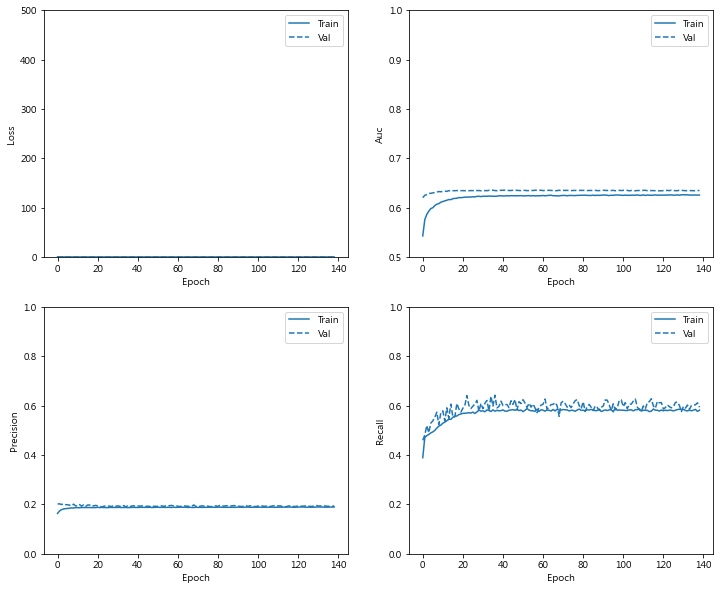

In [130]:
plot_metrics(weighted_history)

In [131]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.6588538289070129
tp :  5383.0
fp :  21491.0
tn :  32246.0
fn :  3722.0
accuracy :  0.5987874269485474
precision :  0.20030513405799866
recall :  0.5912136435508728
auc :  0.6384789943695068

Legitimate Transactions Detected (True Negatives):  32246
Legitimate Transactions Incorrectly Detected (False Positives):  21491
Fraudulent Transactions Missed (False Negatives):  3722
Fraudulent Transactions Detected (True Positives):  5383
Total Fraudulent Transactions:  9105


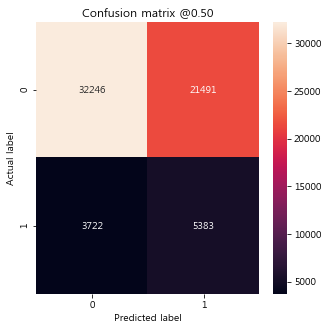

In [132]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

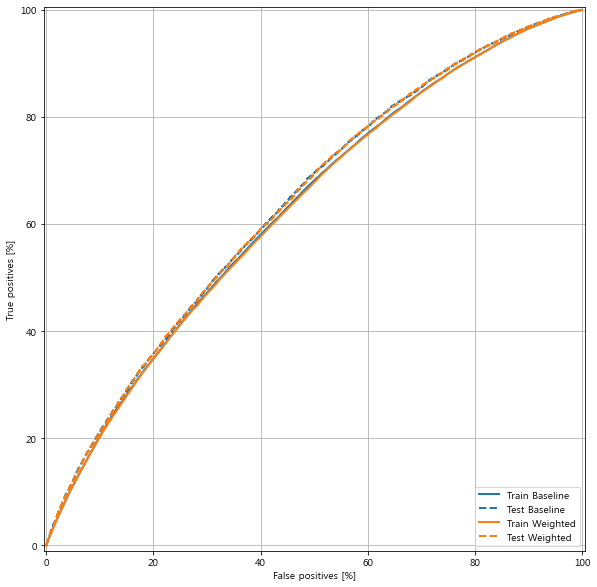

In [133]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [134]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [135]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(378519, 45)

In [136]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(757038, 45)

In [137]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [138]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-0.20855696 -0.20855696 -0.20855696 -0.20855696 -0.20855696 -0.20855696
 -0.20855696 -0.20855696 -0.20855696 -0.20855696 -0.20855696 -0.20855696
  4.79484231 -0.20855696 -0.20855696 -0.20855696 -0.20852728 -0.20841449
 -0.20841449 -0.20841449 -0.20841449 -0.20841449 -0.20841449 -0.20841449
 -0.5674152   0.3424797  -0.01044651 -0.01044651 -0.31202081 -0.07443774
 -0.44028428 -0.08319855 -0.01044651 -0.42886094 -0.05092847 -0.05872872
 -0.08083892  0.73853102 -0.11406655  0.08190203  0.01441899 -0.99999462
  0.99998811  0.67144613  1.15726178]

Label:  1


In [139]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [140]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.4970703125


# Oversampling model

In [141]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

528.0

In [142]:
# resampled_model = make_model()
# resampled_model.load_weights(initial_weights)

# # Reset the bias to zero, since this dataset is balanced.
# output_layer = resampled_model.layers[-1] 
# output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

# resampled_history = resampled_model.fit(
#     resampled_ds,
#     epochs=EPOCHS,
#     steps_per_epoch=resampled_steps_per_epoch,
#     callbacks = [early_stopping],
#     validation_data=val_ds)

In [143]:
# plot_metrics(resampled_history )

In [144]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Epoch 1/100000
20/20 [==============================] - 2s 96ms/step - loss: 0.8041 - tp: 17804.0000 - fp: 33036.0000 - tn: 41306.0000 - fn: 11656.0000 - accuracy: 0.5694 - precision: 0.3502 - recall: 0.6043 - auc: 0.6063 - val_loss: 0.7023 - val_tp: 10036.0000 - val_fp: 49316.0000 - val_tn: 58586.0000 - val_fn: 7745.0000 - val_accuracy: 0.5460 - val_precision: 0.1691 - val_recall: 0.5644 - val_auc: 0.5703
Epoch 2/100000
20/20 [==============================] - 1s 28ms/step - loss: 0.7380 - tp: 11373.0000 - fp: 9238.0000 - tn: 11414.0000 - fn: 8935.0000 - accuracy: 0.5563 - precision: 0.5518 - recall: 0.5600 - auc: 0.5799 - val_loss: 0.6710 - val_tp: 8351.0000 - val_fp: 36249.0000 - val_tn: 71653.0000 - val_fn: 9430.0000 - val_accuracy: 0.6366 - val_precision: 0.1872 - val_recall: 0.4697 - val_auc: 0.5928
Epoch 3/100000
20/20 [==============================] - 1s 28ms/step - loss: 0.7325 - tp: 11489.0000 - fp: 9459.0000 - tn: 11165.0000 - fn: 8847.0000 - accuracy: 0.5531 - precision: 0

20/20 [==============================] - 1s 30ms/step - loss: 0.6780 - tp: 12307.0000 - fp: 9408.0000 - tn: 11097.0000 - fn: 8148.0000 - accuracy: 0.5714 - precision: 0.5668 - recall: 0.6017 - auc: 0.6009 - val_loss: 0.6745 - val_tp: 10610.0000 - val_fp: 45276.0000 - val_tn: 62626.0000 - val_fn: 7171.0000 - val_accuracy: 0.5827 - val_precision: 0.1899 - val_recall: 0.5967 - val_auc: 0.6241
Epoch 22/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6754 - tp: 12141.0000 - fp: 8973.0000 - tn: 11419.0000 - fn: 8427.0000 - accuracy: 0.5752 - precision: 0.5750 - recall: 0.5903 - auc: 0.6070 - val_loss: 0.6694 - val_tp: 10070.0000 - val_fp: 42096.0000 - val_tn: 65806.0000 - val_fn: 7711.0000 - val_accuracy: 0.6037 - val_precision: 0.1930 - val_recall: 0.5663 - val_auc: 0.6246
Epoch 23/100000
20/20 [==============================] - 1s 29ms/step - loss: 0.6764 - tp: 11762.0000 - fp: 8770.0000 - tn: 11785.0000 - fn: 8643.0000 - accuracy: 0.5749 - precision: 0.5729 - recall

20/20 [==============================] - 1s 30ms/step - loss: 0.6723 - tp: 12590.0000 - fp: 9125.0000 - tn: 11231.0000 - fn: 8014.0000 - accuracy: 0.5816 - precision: 0.5798 - recall: 0.6110 - auc: 0.6151 - val_loss: 0.6698 - val_tp: 10554.0000 - val_fp: 44420.0000 - val_tn: 63482.0000 - val_fn: 7227.0000 - val_accuracy: 0.5891 - val_precision: 0.1920 - val_recall: 0.5936 - val_auc: 0.6287
Epoch 42/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6738 - tp: 12141.0000 - fp: 8859.0000 - tn: 11553.0000 - fn: 8407.0000 - accuracy: 0.5785 - precision: 0.5781 - recall: 0.5909 - auc: 0.6121 - val_loss: 0.6741 - val_tp: 10726.0000 - val_fp: 45382.0000 - val_tn: 62520.0000 - val_fn: 7055.0000 - val_accuracy: 0.5828 - val_precision: 0.1912 - val_recall: 0.6032 - val_auc: 0.6292
Epoch 43/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6692 - tp: 12478.0000 - fp: 8756.0000 - tn: 11586.0000 - fn: 8140.0000 - accuracy: 0.5875 - precision: 0.5876 - recall

20/20 [==============================] - 1s 30ms/step - loss: 0.6708 - tp: 12343.0000 - fp: 8641.0000 - tn: 11724.0000 - fn: 8252.0000 - accuracy: 0.5876 - precision: 0.5882 - recall: 0.5993 - auc: 0.6205 - val_loss: 0.6858 - val_tp: 11350.0000 - val_fp: 49192.0000 - val_tn: 58710.0000 - val_fn: 6431.0000 - val_accuracy: 0.5574 - val_precision: 0.1875 - val_recall: 0.6383 - val_auc: 0.6298
Epoch 62/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6663 - tp: 12608.0000 - fp: 8533.0000 - tn: 11833.0000 - fn: 7986.0000 - accuracy: 0.5967 - precision: 0.5964 - recall: 0.6122 - auc: 0.6337 - val_loss: 0.7057 - val_tp: 11849.0000 - val_fp: 52496.0000 - val_tn: 55406.0000 - val_fn: 5932.0000 - val_accuracy: 0.5351 - val_precision: 0.1841 - val_recall: 0.6664 - val_auc: 0.6286
Epoch 63/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6636 - tp: 12719.0000 - fp: 8633.0000 - tn: 11851.0000 - fn: 7757.0000 - accuracy: 0.5999 - precision: 0.5957 - recall

20/20 [==============================] - 1s 30ms/step - loss: 0.6645 - tp: 12309.0000 - fp: 8222.0000 - tn: 12185.0000 - fn: 8244.0000 - accuracy: 0.5980 - precision: 0.5995 - recall: 0.5989 - auc: 0.6373 - val_loss: 0.7063 - val_tp: 11862.0000 - val_fp: 52377.0000 - val_tn: 55525.0000 - val_fn: 5919.0000 - val_accuracy: 0.5362 - val_precision: 0.1847 - val_recall: 0.6671 - val_auc: 0.6286
Epoch 82/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6649 - tp: 12573.0000 - fp: 8608.0000 - tn: 11933.0000 - fn: 7846.0000 - accuracy: 0.5983 - precision: 0.5936 - recall: 0.6158 - auc: 0.6367 - val_loss: 0.7151 - val_tp: 11677.0000 - val_fp: 51939.0000 - val_tn: 55963.0000 - val_fn: 6104.0000 - val_accuracy: 0.5382 - val_precision: 0.1836 - val_recall: 0.6567 - val_auc: 0.6258
Epoch 83/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6642 - tp: 12736.0000 - fp: 8465.0000 - tn: 11895.0000 - fn: 7864.0000 - accuracy: 0.6013 - precision: 0.6007 - recall

20/20 [==============================] - 1s 31ms/step - loss: 0.6632 - tp: 12295.0000 - fp: 8202.0000 - tn: 12250.0000 - fn: 8213.0000 - accuracy: 0.5992 - precision: 0.5998 - recall: 0.5995 - auc: 0.6393 - val_loss: 0.7098 - val_tp: 11370.0000 - val_fp: 50375.0000 - val_tn: 57527.0000 - val_fn: 6411.0000 - val_accuracy: 0.5482 - val_precision: 0.1841 - val_recall: 0.6394 - val_auc: 0.6259
Epoch 102/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6650 - tp: 12711.0000 - fp: 8767.0000 - tn: 11738.0000 - fn: 7744.0000 - accuracy: 0.5969 - precision: 0.5918 - recall: 0.6214 - auc: 0.6339 - val_loss: 0.7068 - val_tp: 10873.0000 - val_fp: 47240.0000 - val_tn: 60662.0000 - val_fn: 6908.0000 - val_accuracy: 0.5692 - val_precision: 0.1871 - val_recall: 0.6115 - val_auc: 0.6255
Epoch 103/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6711 - tp: 12532.0000 - fp: 8867.0000 - tn: 11663.0000 - fn: 7898.0000 - accuracy: 0.5907 - precision: 0.5856 - reca

20/20 [==============================] - 1s 30ms/step - loss: 0.6657 - tp: 12305.0000 - fp: 8387.0000 - tn: 12154.0000 - fn: 8114.0000 - accuracy: 0.5971 - precision: 0.5947 - recall: 0.6026 - auc: 0.6371 - val_loss: 0.6782 - val_tp: 10061.0000 - val_fp: 42437.0000 - val_tn: 65465.0000 - val_fn: 7720.0000 - val_accuracy: 0.6009 - val_precision: 0.1916 - val_recall: 0.5658 - val_auc: 0.6264
Epoch 122/100000
20/20 [==============================] - 1s 32ms/step - loss: 0.6705 - tp: 12295.0000 - fp: 8640.0000 - tn: 11782.0000 - fn: 8243.0000 - accuracy: 0.5878 - precision: 0.5873 - recall: 0.5986 - auc: 0.6272 - val_loss: 0.6619 - val_tp: 9736.0000 - val_fp: 40823.0000 - val_tn: 67079.0000 - val_fn: 8045.0000 - val_accuracy: 0.6112 - val_precision: 0.1926 - val_recall: 0.5476 - val_auc: 0.6245
Epoch 123/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6744 - tp: 12631.0000 - fp: 9368.0000 - tn: 11080.0000 - fn: 7881.0000 - accuracy: 0.5789 - precision: 0.5742 - recal

20/20 [==============================] - 1s 31ms/step - loss: 0.6713 - tp: 12621.0000 - fp: 8949.0000 - tn: 11435.0000 - fn: 7955.0000 - accuracy: 0.5873 - precision: 0.5851 - recall: 0.6134 - auc: 0.6219 - val_loss: 0.6571 - val_tp: 9852.0000 - val_fp: 41411.0000 - val_tn: 66491.0000 - val_fn: 7929.0000 - val_accuracy: 0.6074 - val_precision: 0.1922 - val_recall: 0.5541 - val_auc: 0.6226
Epoch 142/100000
20/20 [==============================] - 1s 33ms/step - loss: 0.6757 - tp: 12785.0000 - fp: 9515.0000 - tn: 10848.0000 - fn: 7812.0000 - accuracy: 0.5770 - precision: 0.5733 - recall: 0.6207 - auc: 0.6085 - val_loss: 0.6579 - val_tp: 10352.0000 - val_fp: 44127.0000 - val_tn: 63775.0000 - val_fn: 7429.0000 - val_accuracy: 0.5898 - val_precision: 0.1900 - val_recall: 0.5822 - val_auc: 0.6238
Epoch 143/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6762 - tp: 12815.0000 - fp: 10094.0000 - tn: 10490.0000 - fn: 7561.0000 - accuracy: 0.5690 - precision: 0.5594 - reca

20/20 [==============================] - 1s 31ms/step - loss: 0.6738 - tp: 12878.0000 - fp: 9712.0000 - tn: 10778.0000 - fn: 7592.0000 - accuracy: 0.5775 - precision: 0.5701 - recall: 0.6291 - auc: 0.6111 - val_loss: 0.6557 - val_tp: 10506.0000 - val_fp: 44677.0000 - val_tn: 63225.0000 - val_fn: 7275.0000 - val_accuracy: 0.5866 - val_precision: 0.1904 - val_recall: 0.5909 - val_auc: 0.6262
Epoch 162/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6760 - tp: 12800.0000 - fp: 9925.0000 - tn: 10576.0000 - fn: 7659.0000 - accuracy: 0.5707 - precision: 0.5633 - recall: 0.6256 - auc: 0.6064 - val_loss: 0.6630 - val_tp: 10979.0000 - val_fp: 47418.0000 - val_tn: 60484.0000 - val_fn: 6802.0000 - val_accuracy: 0.5686 - val_precision: 0.1880 - val_recall: 0.6175 - val_auc: 0.6283
Epoch 163/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6695 - tp: 13388.0000 - fp: 9884.0000 - tn: 10627.0000 - fn: 7061.0000 - accuracy: 0.5863 - precision: 0.5753 - reca

20/20 [==============================] - 1s 30ms/step - loss: 0.6723 - tp: 13050.0000 - fp: 9900.0000 - tn: 10653.0000 - fn: 7357.0000 - accuracy: 0.5787 - precision: 0.5686 - recall: 0.6395 - auc: 0.6161 - val_loss: 0.6674 - val_tp: 11200.0000 - val_fp: 48606.0000 - val_tn: 59296.0000 - val_fn: 6581.0000 - val_accuracy: 0.5609 - val_precision: 0.1873 - val_recall: 0.6299 - val_auc: 0.6290
Epoch 182/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6654 - tp: 13185.0000 - fp: 9323.0000 - tn: 11108.0000 - fn: 7344.0000 - accuracy: 0.5931 - precision: 0.5858 - recall: 0.6423 - auc: 0.6342 - val_loss: 0.6743 - val_tp: 11585.0000 - val_fp: 50569.0000 - val_tn: 57333.0000 - val_fn: 6196.0000 - val_accuracy: 0.5483 - val_precision: 0.1864 - val_recall: 0.6515 - val_auc: 0.6305
Epoch 183/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6627 - tp: 13158.0000 - fp: 9253.0000 - tn: 11271.0000 - fn: 7278.0000 - accuracy: 0.5964 - precision: 0.5871 - reca

20/20 [==============================] - 1s 30ms/step - loss: 0.6629 - tp: 12287.0000 - fp: 7946.0000 - tn: 12467.0000 - fn: 8260.0000 - accuracy: 0.6043 - precision: 0.6073 - recall: 0.5980 - auc: 0.6436 - val_loss: 0.6939 - val_tp: 12002.0000 - val_fp: 52968.0000 - val_tn: 54934.0000 - val_fn: 5779.0000 - val_accuracy: 0.5326 - val_precision: 0.1847 - val_recall: 0.6750 - val_auc: 0.6303
Epoch 202/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6592 - tp: 12379.0000 - fp: 8144.0000 - tn: 12466.0000 - fn: 7971.0000 - accuracy: 0.6066 - precision: 0.6032 - recall: 0.6083 - auc: 0.6494 - val_loss: 0.7009 - val_tp: 12281.0000 - val_fp: 54882.0000 - val_tn: 53020.0000 - val_fn: 5500.0000 - val_accuracy: 0.5196 - val_precision: 0.1829 - val_recall: 0.6907 - val_auc: 0.6296
Epoch 203/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6578 - tp: 12701.0000 - fp: 8021.0000 - tn: 12264.0000 - fn: 7974.0000 - accuracy: 0.6095 - precision: 0.6129 - reca

20/20 [==============================] - 1s 30ms/step - loss: 0.6599 - tp: 12683.0000 - fp: 8277.0000 - tn: 12220.0000 - fn: 7780.0000 - accuracy: 0.6080 - precision: 0.6051 - recall: 0.6198 - auc: 0.6486 - val_loss: 0.6989 - val_tp: 12371.0000 - val_fp: 55419.0000 - val_tn: 52483.0000 - val_fn: 5410.0000 - val_accuracy: 0.5160 - val_precision: 0.1825 - val_recall: 0.6957 - val_auc: 0.6297
Epoch 222/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6683 - tp: 12597.0000 - fp: 8741.0000 - tn: 11680.0000 - fn: 7942.0000 - accuracy: 0.5927 - precision: 0.5904 - recall: 0.6133 - auc: 0.6288 - val_loss: 0.7078 - val_tp: 12730.0000 - val_fp: 57987.0000 - val_tn: 49915.0000 - val_fn: 5051.0000 - val_accuracy: 0.4984 - val_precision: 0.1800 - val_recall: 0.7159 - val_auc: 0.6298
Epoch 223/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6881 - tp: 12425.0000 - fp: 10266.0000 - tn: 10038.0000 - fn: 8231.0000 - accuracy: 0.5484 - precision: 0.5476 - rec

20/20 [==============================] - 1s 31ms/step - loss: 0.6888 - tp: 12352.0000 - fp: 10374.0000 - tn: 10111.0000 - fn: 8123.0000 - accuracy: 0.5484 - precision: 0.5435 - recall: 0.6033 - auc: 0.5767 - val_loss: 0.6807 - val_tp: 11855.0000 - val_fp: 51753.0000 - val_tn: 56149.0000 - val_fn: 5926.0000 - val_accuracy: 0.5411 - val_precision: 0.1864 - val_recall: 0.6667 - val_auc: 0.6313
Epoch 242/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6778 - tp: 12050.0000 - fp: 9315.0000 - tn: 11264.0000 - fn: 8331.0000 - accuracy: 0.5692 - precision: 0.5640 - recall: 0.5912 - auc: 0.6002 - val_loss: 0.6589 - val_tp: 10698.0000 - val_fp: 45098.0000 - val_tn: 62804.0000 - val_fn: 7083.0000 - val_accuracy: 0.5848 - val_precision: 0.1917 - val_recall: 0.6017 - val_auc: 0.6325
Epoch 243/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6708 - tp: 12355.0000 - fp: 8885.0000 - tn: 11602.0000 - fn: 8118.0000 - accuracy: 0.5849 - precision: 0.5817 - rec

20/20 [==============================] - 1s 29ms/step - loss: 0.6716 - tp: 12235.0000 - fp: 8898.0000 - tn: 11687.0000 - fn: 8140.0000 - accuracy: 0.5840 - precision: 0.5790 - recall: 0.6005 - auc: 0.6177 - val_loss: 0.6581 - val_tp: 10805.0000 - val_fp: 45718.0000 - val_tn: 62184.0000 - val_fn: 6976.0000 - val_accuracy: 0.5807 - val_precision: 0.1912 - val_recall: 0.6077 - val_auc: 0.6330
Epoch 262/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6697 - tp: 12477.0000 - fp: 9335.0000 - tn: 11439.0000 - fn: 7709.0000 - accuracy: 0.5839 - precision: 0.5720 - recall: 0.6181 - auc: 0.6212 - val_loss: 0.6506 - val_tp: 10573.0000 - val_fp: 44275.0000 - val_tn: 63627.0000 - val_fn: 7208.0000 - val_accuracy: 0.5904 - val_precision: 0.1928 - val_recall: 0.5946 - val_auc: 0.6334
Epoch 263/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6730 - tp: 12609.0000 - fp: 9207.0000 - tn: 11172.0000 - fn: 7972.0000 - accuracy: 0.5806 - precision: 0.5780 - reca

20/20 [==============================] - 1s 30ms/step - loss: 0.6701 - tp: 12542.0000 - fp: 9202.0000 - tn: 11360.0000 - fn: 7856.0000 - accuracy: 0.5835 - precision: 0.5768 - recall: 0.6149 - auc: 0.6206 - val_loss: 0.6532 - val_tp: 10729.0000 - val_fp: 45010.0000 - val_tn: 62892.0000 - val_fn: 7052.0000 - val_accuracy: 0.5858 - val_precision: 0.1925 - val_recall: 0.6034 - val_auc: 0.6336
Epoch 282/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6692 - tp: 12629.0000 - fp: 9000.0000 - tn: 11510.0000 - fn: 7821.0000 - accuracy: 0.5893 - precision: 0.5839 - recall: 0.6176 - auc: 0.6245 - val_loss: 0.6584 - val_tp: 10973.0000 - val_fp: 46627.0000 - val_tn: 61275.0000 - val_fn: 6808.0000 - val_accuracy: 0.5748 - val_precision: 0.1905 - val_recall: 0.6171 - val_auc: 0.6333
Epoch 283/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6680 - tp: 12744.0000 - fp: 8947.0000 - tn: 11543.0000 - fn: 7726.0000 - accuracy: 0.5929 - precision: 0.5875 - reca

20/20 [==============================] - 1s 30ms/step - loss: 0.6684 - tp: 12766.0000 - fp: 9166.0000 - tn: 11432.0000 - fn: 7596.0000 - accuracy: 0.5908 - precision: 0.5821 - recall: 0.6270 - auc: 0.6265 - val_loss: 0.6636 - val_tp: 11087.0000 - val_fp: 47221.0000 - val_tn: 60681.0000 - val_fn: 6694.0000 - val_accuracy: 0.5710 - val_precision: 0.1901 - val_recall: 0.6235 - val_auc: 0.6333
Epoch 302/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6659 - tp: 12695.0000 - fp: 8619.0000 - tn: 11736.0000 - fn: 7910.0000 - accuracy: 0.5965 - precision: 0.5956 - recall: 0.6161 - auc: 0.6325 - val_loss: 0.6796 - val_tp: 11631.0000 - val_fp: 50673.0000 - val_tn: 57229.0000 - val_fn: 6150.0000 - val_accuracy: 0.5479 - val_precision: 0.1867 - val_recall: 0.6541 - val_auc: 0.6316
Epoch 303/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6631 - tp: 12467.0000 - fp: 8483.0000 - tn: 12131.0000 - fn: 7879.0000 - accuracy: 0.6005 - precision: 0.5951 - reca

20/20 [==============================] - 1s 30ms/step - loss: 0.6654 - tp: 12612.0000 - fp: 8848.0000 - tn: 11744.0000 - fn: 7756.0000 - accuracy: 0.5946 - precision: 0.5877 - recall: 0.6192 - auc: 0.6337 - val_loss: 0.6770 - val_tp: 11440.0000 - val_fp: 49818.0000 - val_tn: 58084.0000 - val_fn: 6341.0000 - val_accuracy: 0.5532 - val_precision: 0.1868 - val_recall: 0.6434 - val_auc: 0.6304
Epoch 322/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6626 - tp: 12353.0000 - fp: 8239.0000 - tn: 12248.0000 - fn: 8120.0000 - accuracy: 0.6006 - precision: 0.5999 - recall: 0.6034 - auc: 0.6409 - val_loss: 0.6874 - val_tp: 11420.0000 - val_fp: 50156.0000 - val_tn: 57746.0000 - val_fn: 6361.0000 - val_accuracy: 0.5503 - val_precision: 0.1855 - val_recall: 0.6423 - val_auc: 0.6275
Epoch 323/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6622 - tp: 12381.0000 - fp: 8312.0000 - tn: 12349.0000 - fn: 7918.0000 - accuracy: 0.6038 - precision: 0.5983 - reca

20/20 [==============================] - 1s 30ms/step - loss: 0.6621 - tp: 12572.0000 - fp: 8358.0000 - tn: 12141.0000 - fn: 7889.0000 - accuracy: 0.6033 - precision: 0.6007 - recall: 0.6144 - auc: 0.6424 - val_loss: 0.6821 - val_tp: 11281.0000 - val_fp: 49311.0000 - val_tn: 58591.0000 - val_fn: 6500.0000 - val_accuracy: 0.5559 - val_precision: 0.1862 - val_recall: 0.6344 - val_auc: 0.6276
Epoch 342/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6635 - tp: 12334.0000 - fp: 8439.0000 - tn: 12132.0000 - fn: 8055.0000 - accuracy: 0.5973 - precision: 0.5938 - recall: 0.6049 - auc: 0.6372 - val_loss: 0.6696 - val_tp: 10708.0000 - val_fp: 46035.0000 - val_tn: 61867.0000 - val_fn: 7073.0000 - val_accuracy: 0.5774 - val_precision: 0.1887 - val_recall: 0.6022 - val_auc: 0.6273
Epoch 343/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6671 - tp: 12428.0000 - fp: 8683.0000 - tn: 11876.0000 - fn: 7973.0000 - accuracy: 0.5934 - precision: 0.5887 - reca

20/20 [==============================] - 1s 30ms/step - loss: 0.6659 - tp: 12226.0000 - fp: 8625.0000 - tn: 12032.0000 - fn: 8077.0000 - accuracy: 0.5922 - precision: 0.5864 - recall: 0.6022 - auc: 0.6331 - val_loss: 0.6700 - val_tp: 10499.0000 - val_fp: 44570.0000 - val_tn: 63332.0000 - val_fn: 7282.0000 - val_accuracy: 0.5874 - val_precision: 0.1907 - val_recall: 0.5905 - val_auc: 0.6281
Epoch 362/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6691 - tp: 12804.0000 - fp: 8897.0000 - tn: 11307.0000 - fn: 7952.0000 - accuracy: 0.5886 - precision: 0.5900 - recall: 0.6169 - auc: 0.6252 - val_loss: 0.6679 - val_tp: 10560.0000 - val_fp: 44970.0000 - val_tn: 62932.0000 - val_fn: 7221.0000 - val_accuracy: 0.5847 - val_precision: 0.1902 - val_recall: 0.5939 - val_auc: 0.6280
Epoch 363/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6715 - tp: 12850.0000 - fp: 9443.0000 - tn: 10987.0000 - fn: 7680.0000 - accuracy: 0.5820 - precision: 0.5764 - reca

20/20 [==============================] - 1s 30ms/step - loss: 0.6697 - tp: 13135.0000 - fp: 9481.0000 - tn: 10744.0000 - fn: 7600.0000 - accuracy: 0.5830 - precision: 0.5808 - recall: 0.6335 - auc: 0.6215 - val_loss: 0.6635 - val_tp: 10816.0000 - val_fp: 46688.0000 - val_tn: 61214.0000 - val_fn: 6965.0000 - val_accuracy: 0.5731 - val_precision: 0.1881 - val_recall: 0.6083 - val_auc: 0.6270
Epoch 382/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6722 - tp: 13435.0000 - fp: 10146.0000 - tn: 10222.0000 - fn: 7157.0000 - accuracy: 0.5776 - precision: 0.5697 - recall: 0.6524 - auc: 0.6153 - val_loss: 0.6601 - val_tp: 10967.0000 - val_fp: 47513.0000 - val_tn: 60389.0000 - val_fn: 6814.0000 - val_accuracy: 0.5677 - val_precision: 0.1875 - val_recall: 0.6168 - val_auc: 0.6263
Epoch 383/100000
20/20 [==============================] - 1s 31ms/step - loss: 0.6741 - tp: 13325.0000 - fp: 10290.0000 - tn: 10216.0000 - fn: 7129.0000 - accuracy: 0.5747 - precision: 0.5643 - re

20/20 [==============================] - 1s 30ms/step - loss: 0.6734 - tp: 12905.0000 - fp: 9612.0000 - tn: 10772.0000 - fn: 7671.0000 - accuracy: 0.5781 - precision: 0.5731 - recall: 0.6272 - auc: 0.6123 - val_loss: 0.6585 - val_tp: 10836.0000 - val_fp: 46765.0000 - val_tn: 61137.0000 - val_fn: 6945.0000 - val_accuracy: 0.5727 - val_precision: 0.1881 - val_recall: 0.6094 - val_auc: 0.6262
Epoch 402/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6772 - tp: 13319.0000 - fp: 10382.0000 - tn: 10024.0000 - fn: 7235.0000 - accuracy: 0.5699 - precision: 0.5620 - recall: 0.6480 - auc: 0.6027 - val_loss: 0.6678 - val_tp: 11510.0000 - val_fp: 50203.0000 - val_tn: 57699.0000 - val_fn: 6271.0000 - val_accuracy: 0.5507 - val_precision: 0.1865 - val_recall: 0.6473 - val_auc: 0.6282
Epoch 403/100000
20/20 [==============================] - 1s 29ms/step - loss: 0.6695 - tp: 13164.0000 - fp: 9749.0000 - tn: 10827.0000 - fn: 7220.0000 - accuracy: 0.5857 - precision: 0.5745 - rec

20/20 [==============================] - 1s 30ms/step - loss: 0.6705 - tp: 13500.0000 - fp: 10282.0000 - tn: 10247.0000 - fn: 6931.0000 - accuracy: 0.5798 - precision: 0.5677 - recall: 0.6608 - auc: 0.6200 - val_loss: 0.6734 - val_tp: 11873.0000 - val_fp: 51936.0000 - val_tn: 55966.0000 - val_fn: 5908.0000 - val_accuracy: 0.5398 - val_precision: 0.1861 - val_recall: 0.6677 - val_auc: 0.6317
Epoch 422/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6671 - tp: 13487.0000 - fp: 9746.0000 - tn: 10682.0000 - fn: 7045.0000 - accuracy: 0.5901 - precision: 0.5805 - recall: 0.6569 - auc: 0.6287 - val_loss: 0.6850 - val_tp: 12194.0000 - val_fp: 53626.0000 - val_tn: 54276.0000 - val_fn: 5587.0000 - val_accuracy: 0.5289 - val_precision: 0.1853 - val_recall: 0.6858 - val_auc: 0.6322
Epoch 423/100000
20/20 [==============================] - 1s 30ms/step - loss: 0.6634 - tp: 13350.0000 - fp: 9136.0000 - tn: 11261.0000 - fn: 7213.0000 - accuracy: 0.6009 - precision: 0.5937 - rec

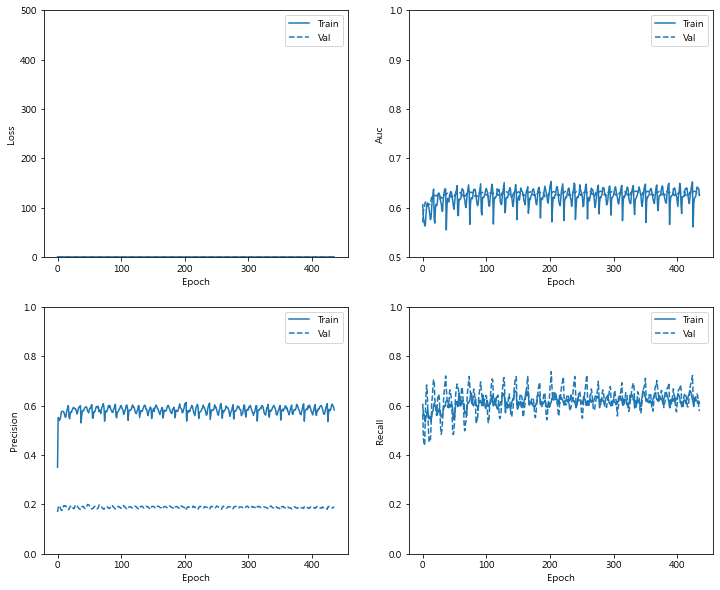

In [145]:
plot_metrics(resampled_history)

In [146]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.6715673208236694
tp :  5908.0
fp :  24675.0
tn :  29062.0
fn :  3197.0
accuracy :  0.5564749836921692
precision :  0.19317921996116638
recall :  0.6488742232322693
auc :  0.6371849179267883

Legitimate Transactions Detected (True Negatives):  29062
Legitimate Transactions Incorrectly Detected (False Positives):  24675
Fraudulent Transactions Missed (False Negatives):  3197
Fraudulent Transactions Detected (True Positives):  5908
Total Fraudulent Transactions:  9105


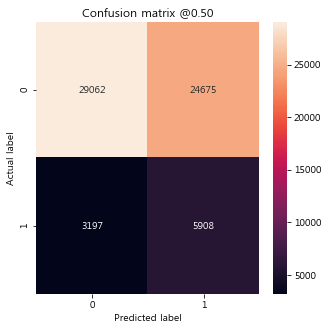

In [147]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

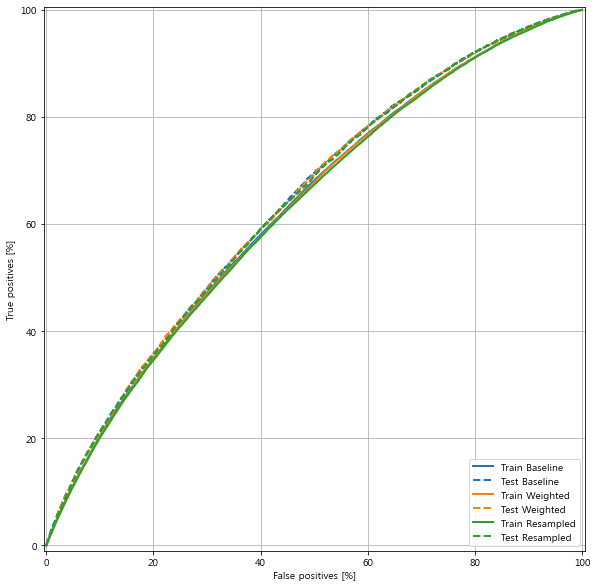

In [148]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

In [149]:
df.shape

(628416, 46)